## Vision por computadora 1 - FIUBA
### Parte 1 (imágenes en white_patch y coord_cromaticas)
#### 1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de constraste.

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

Cuando R, G y B son todos simultáneamente 0, el algoritmo tiene problemas ya que no está definida la división por 0. 

Es por ese motivo que se agrega un epsilon con un valor muy pequeño de modo tal que el código no imprima una excepción.

In [20]:
def get_chromatic_coordinates(rgb_img, epsilon=1e-30):
    # Convert to float64 and sum channels to avoid division by zero
    rgb_img = rgb_img.astype(np.float64)
    divider = rgb_img.sum(axis=2, keepdims=True) + epsilon
    return rgb_img / divider

In [21]:
def show_images_from_folder(folder_path, callback=None):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error al abrir la imagen: {img_path}")
                continue
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            plt.imshow(image_rgb)
            plt.title(filename)
            plt.axis('off')
            plt.show()

            if callback is not None:
                image_rgb_modified = callback(image_rgb)
                plt.imshow(image_rgb_modified)
                plt.title('modified_' + filename)
                plt.axis('off')
                plt.show()

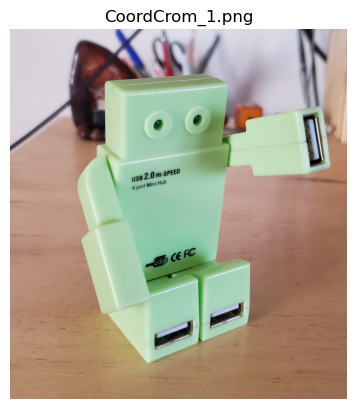

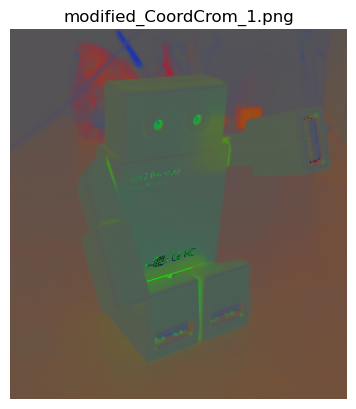

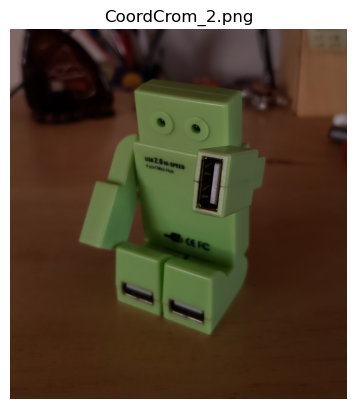

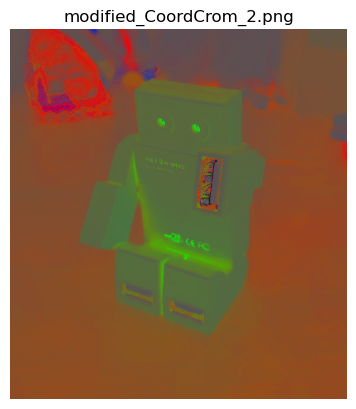

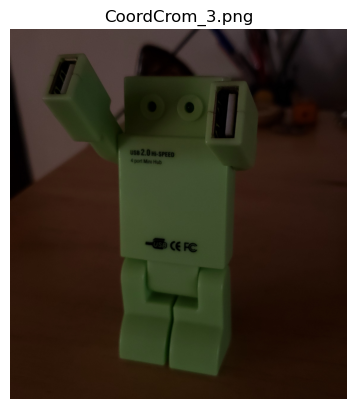

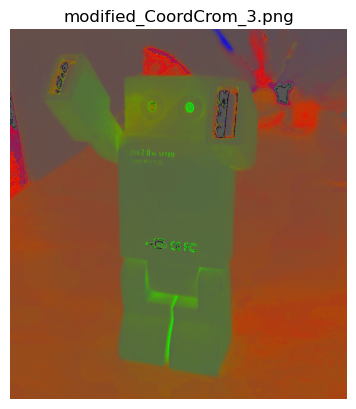

In [22]:
folder_path_cc = 'tp1_resources/coord_cromaticas'
show_images_from_folder(folder_path_cc, callback=get_chromatic_coordinates)

#### 2.Implementar el algoritmo de White Patch para librarnos de las diferencias de color de iluminación

In [23]:
def white_patch(rgb_image):
    r = rgb_image[:, :, 0].astype(np.float64)
    g = rgb_image[:, :, 1].astype(np.float64)
    b = rgb_image[:, :, 2].astype(np.float64)

    max_r = np.max(r)
    max_g = np.max(g)
    max_b = np.max(b)

    # mask = (r + g + b) > 0
    mask_r = r  > 0
    mask_g = g  > 0
    mask_b = b  > 0
    
    ans = np.zeros_like(rgb_image, dtype=np.float64)

    # ans[mask, 0] = r[mask] * 255 / max_r
    # ans[mask, 1] = g[mask] * 255 / max_g
    # ans[mask, 2] = b[mask] * 255 / max_b

    ans[mask_r, 0] = r[mask_r] * 255 / max_r
    ans[mask_g, 1] = g[mask_g] * 255 / max_g
    ans[mask_b, 2] = b[mask_b] * 255 / max_b

    
    ans = np.clip(ans, 0, 255) 

    return ans.astype(np.uint8)

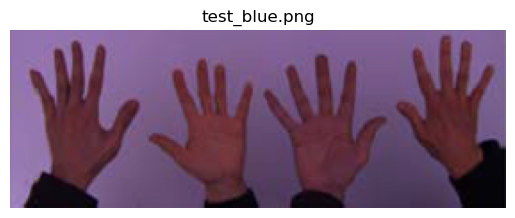

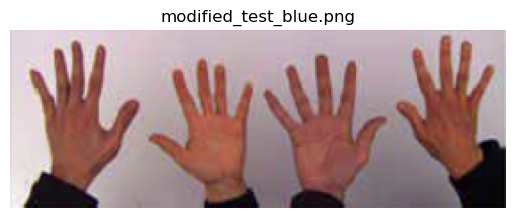

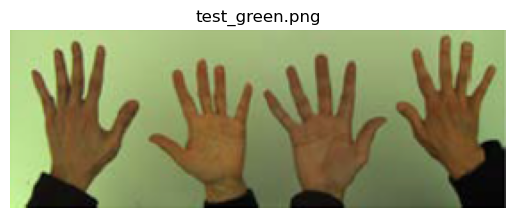

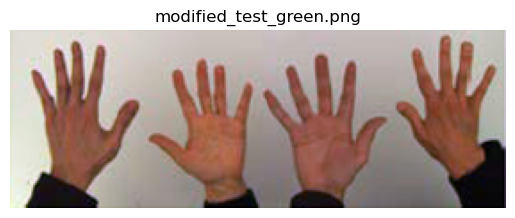

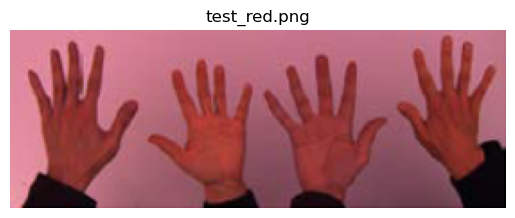

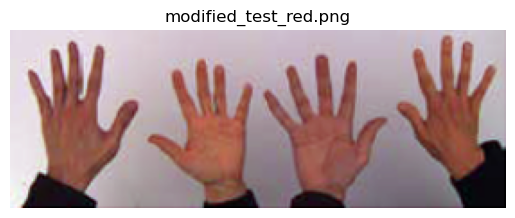

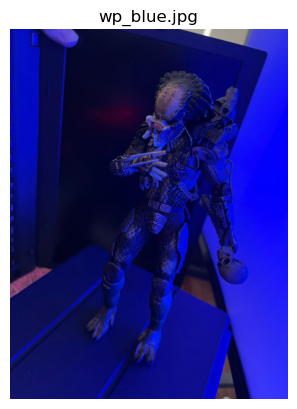

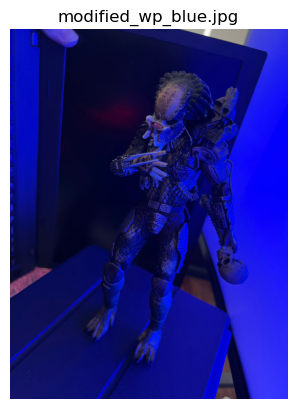

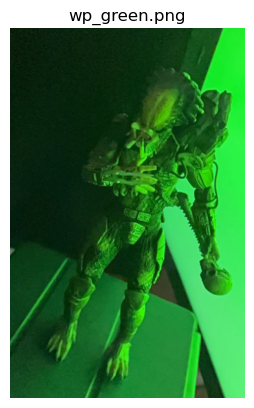

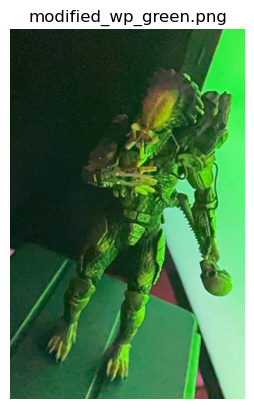

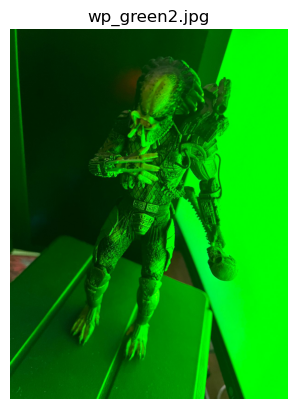

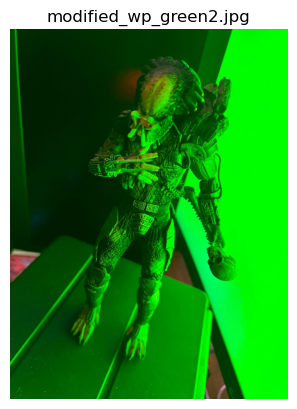

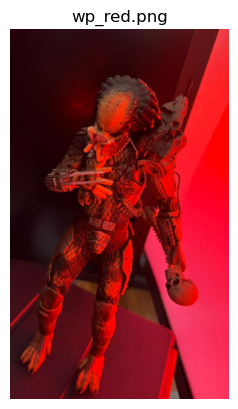

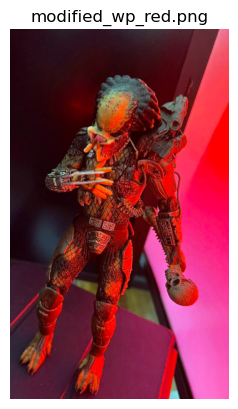

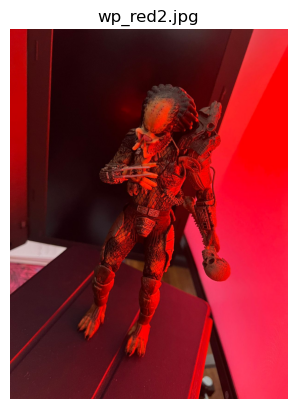

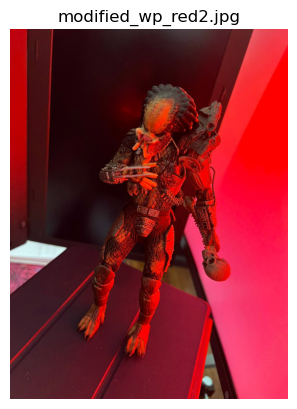

In [24]:
folder_path_wp = 'tp1_resources/white_patch/'
show_images_from_folder(folder_path_wp, callback=white_patch)

### Análisis White Patch:

Si hay objetos en la imagen que son verdaderamente blancos o claros, el método puede hacer que estos se sobreexpongan, lo que puede hacer que se pierda información visual importante. 

En imágenes donde los colores son muy saturados, la corrección puede llevar a valores que caen fuera del rango de visualización. Esto se resuelve haciendo un clipping, lo que a su vez trae aparejada una saturación de la imagen. Este efecto es particularmente notorio, por ejemplo, en imágenes como _wp_green2.jpg_.

Por otro lado, si la imagen tiene una gran cantidad de píxeles oscuros (cercanos a cero) y pocos píxeles claros, el método puede ajustar incorrectamente los valores de los píxeles, ya que intenta normalizar todo en función de los máximos.

### Parte 2
#### 1.

In [25]:
def read_show_grayscale(filename):
    image = cv2.imread(filename)
    image_gs = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
            
    plt.imshow(image_gs, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    plt.show()
    
    return image_gs

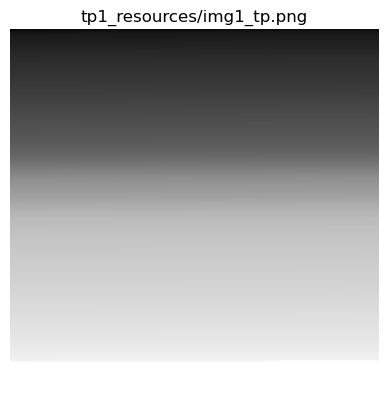

In [26]:
img1 = read_show_grayscale('tp1_resources/img1_tp.png')

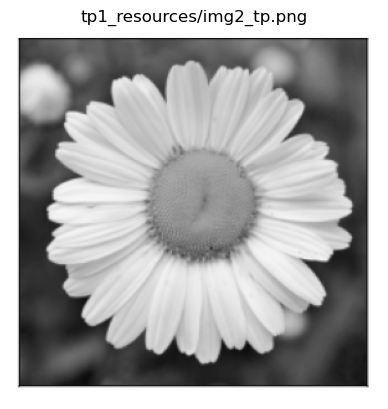

In [27]:
img2 = read_show_grayscale('tp1_resources/img2_tp.png')

#### 2.

In [28]:
def plot_histogram(image, bins=256):
    plt.hist(image.ravel(), bins=bins, range=[0, 256])
    plt.title('Histograma')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')

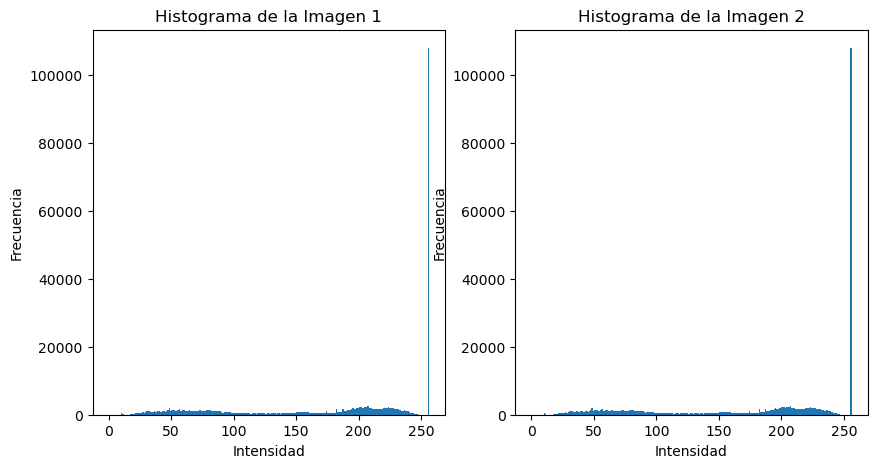

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_histogram(img1)
plt.title('Histograma de la Imagen 1')
plt.subplot(1, 2, 2)
plot_histogram(img2)
plt.title('Histograma de la Imagen 2')
plt.show()

Ambos histogramas presentan una distribución similar en intensidad, con un pico alrededor del valor 255. Esto dice que ambas imágenes contienen una gran cantidad de píxeles de tonos muy claros o blancos.

Como los dos histogramas son casi idénticos, ambas imágenes contienen información lumínica muy similar (aunque realmente sean imagenes muy diferentes). Si se usaran estos histogramas como features en un modelo de clasificación o detección, podrían no aportar suficiente información para permitir clasificar correctamente y diferenciarlas. En ese caso, se podría considerar agregar otras features, como texturas o formas, para mejorar la clasificación.

#### 3.

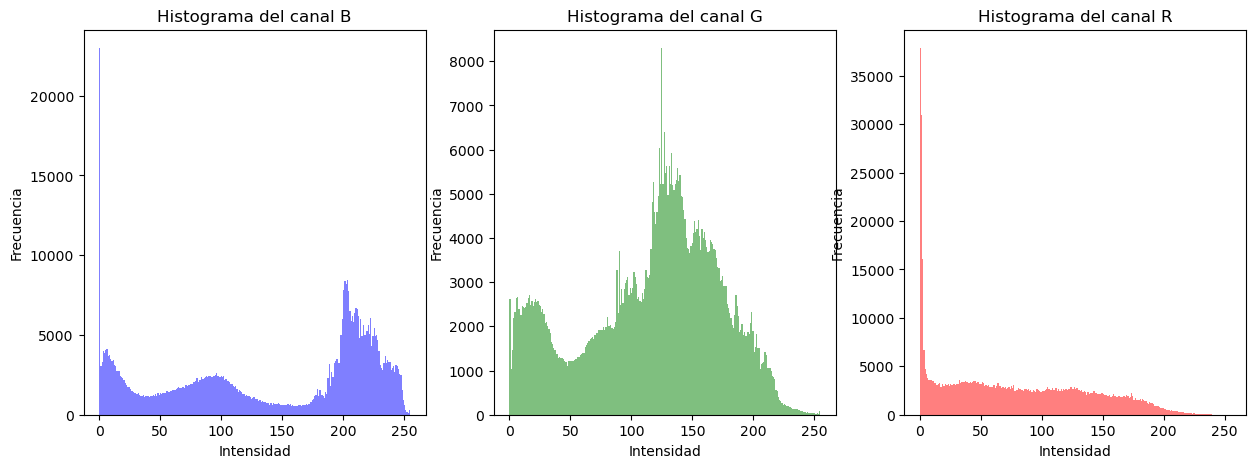

In [98]:
img_segmentation = cv2.imread('tp1_resources/segmentacion.png')

channels = cv2.split(img_segmentation)
colors = ('b', 'g', 'r')
plt.figure(figsize=(15, 5))


for i, channel in enumerate(channels):
    plt.subplot(1, 3, i + 1)
    plt.hist(channel.ravel(), bins=256, color=colors[i], alpha=0.5)
    plt.title(f'Histograma del canal {colors[i].upper()}')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')
    
plt.show()

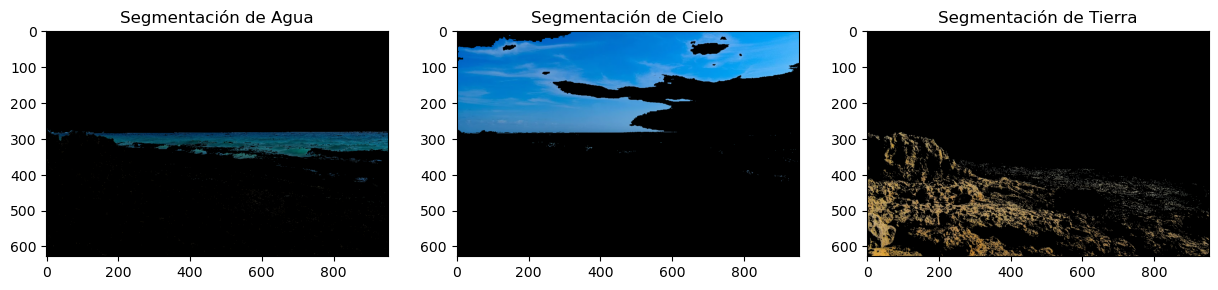

In [230]:
# Agua
mask_water = cv2.inRange(img_segmentation, (0, 40, 0), (170, 255, 50))

# Cielo
mask_sky = cv2.inRange(img_segmentation, (170, 100, 0), (255, 200, 100))

# Tierra
mask_land = cv2.inRange(img_segmentation, (0, 50, 130), (140, 255, 255))

water_segment = cv2.bitwise_and(img_segmentation, img_segmentation, mask=mask_water)
sky_segment = cv2.bitwise_and(img_segmentation, img_segmentation, mask=mask_sky)
land_segment = cv2.bitwise_and(img_segmentation, img_segmentation, mask=mask_land)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(water_segment, cv2.COLOR_BGR2RGB))
plt.title('Segmentación de Agua')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(sky_segment, cv2.COLOR_BGR2RGB))
plt.title('Segmentación de Cielo')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(land_segment, cv2.COLOR_BGR2RGB))
plt.title('Segmentación de Tierra')
plt.show()
